In [45]:
import sys
sys.path.append('../../src')
import pandas
import random
import math
import matplotlib.pyplot as plt
from matplotlib import rc
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.process import Process, ProcessMode, VaryingProcess
from energiapy.components.location import Location
from energiapy.components.transport import Transport, VaryingTransport
from energiapy.components.network import Network
from energiapy.components.scenario import Scenario
from energiapy.model.constraints.demand import constraint_demand2
from energiapy.components.result import Result
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.plot import plot_results, plot_scenario, plot_location
from energiapy.model.solve import solve
from pyomo.environ import Param
from energiapy.utils.scale_utils import scale_pyomo_set

In [46]:
_time_intervals = 30  # Number of time intervals in a planning horizon    (L_chi)
_coms = 1
_exec_scenarios = 12  # Number of execution scenarios                     (chi)

M = 1e3  # Big M

init = [1]

# loc1_varying_factor = pandas.DataFrame(data={'com1_pur': init+[round(random.uniform(0, 0.75), 2) for _ in range(_exec_scenarios-1)]})

transport_varying_factor = pandas.DataFrame(data={
    'truck30_25': [1, 0.09, 0.42, 0.09, 0.7, 0.42, 0.43, 0.68, 0.1, 0.43, 0.38, 0.74],
    'truck100_45': [1, 0.63, 0.38, 0.17, 0.08, 0.03, 0.59, 0.5, 0.74, 0.11, 0.21, 0.14],
    'truck20_34': [1, 0.14, 0.01, 0.26, 0.59, 0.21, 0.55, 0.0, 0.66, 0.02, 0.22, 0.24]
})

# Define temporal scales
scales = TemporalScale(discretization_list=[1, _exec_scenarios, _time_intervals])

demand_factor = [1]*_exec_scenarios

In [47]:
# init+[round(random.uniform(0, 0.75), 2) for _ in range(_exec_scenarios-1)]

[1, 0.45, 0.58, 0.01, 0.53, 0.02, 0.26, 0.44, 0.56, 0.17, 0.43, 0.7]

In [48]:
# ======================================================================================================================
# Declare resources/commodities
# ======================================================================================================================

com1_pur = Resource(name='com1_pur', cons_max=100, block={'imp': 1, 'urg': 1}, price=0.00, label='Commodity 1 consumed from outside the system')

com1_in = Resource(name='com1_in', label='Commodity 1 received')
com1_out = Resource(name='com1_out', label='Commodity 1 to be sent out')

com1_loc1_out = Resource(name='com1_loc1_out', label='Commodity 1 sent out from location 1')
com1_loc2_out = Resource(name='com1_loc2_out', label='Commodity 1 sent out from location 2')
com1_loc3_out = Resource(name='com1_loc3_out', label='Commodity 1 sent out from location 3')
com1_loc4_out = Resource(name='com1_loc4_out', label='Commodity 1 sent out from location 4')
com1_loc5_out = Resource(name='com1_loc5_out', label='Commodity 1 sent out from location 5')
com1_loc6_out = Resource(name='com1_loc6_out', label='Commodity 1 sent out from location 6')
com1_loc7_out = Resource(name='com1_loc7_out', label='Commodity 1 sent out from location 7')

com1_sold = Resource(name='com1_sold', revenue=0.00, demand=True, sell=True, label='Commodity 1 sold to outside the system')

In [49]:
# ======================================================================================================================
# Declare processes/storage capacities
# ======================================================================================================================
com1_procure = Process(name='procure com1', prod_max=100, conversion={com1_pur: -1, com1_in: 1}, capex=0.1, vopex=0.1, fopex=0.1, prod_min=0.001,
                  label='Procure com1')
com1_sell = Process(name='sell com1', prod_max=M, conversion={com1_out: -1, com1_sold: 1}, capex=0.1, vopex=0.1, fopex=0.1,
                  label='Sell com1')

com1_receive_loc1 = Process(name='com1_receive_loc1', prod_max=125, conversion={com1_loc1_out:-1, com1_in:1}, capex=0.1, vopex=0.1, fopex=0.1, prod_min=0.001,
                            label='Commodity 1 received from location 1')
com1_receive_loc2 = Process(name='com1_receive_loc2', prod_max=125, conversion={com1_loc2_out:-1, com1_in:1}, capex=0.1, vopex=0.1, fopex=0.1, prod_min=0.001,
                            label='Commodity 1 received from location 2')
com1_receive_loc3 = Process(name='com1_receive_loc3', prod_max=125, conversion={com1_loc3_out:-1, com1_in:1}, capex=0.1, vopex=0.1, fopex=0.1, prod_min=0.001,
                            label='Commodity 1 received from location 3')
com1_receive_loc4 = Process(name='com1_receive_loc4', prod_max=125, conversion={com1_loc4_out:-1, com1_in:1}, capex=0.1, vopex=0.1, fopex=0.1, prod_min=0.001,
                            label='Commodity 1 received from location 4')
com1_receive_loc5 = Process(name='com1_receive_loc5', prod_max=125, conversion={com1_loc5_out:-1, com1_in:1}, capex=0.1, vopex=0.1, fopex=0.1, prod_min=0.001,
                            label='Commodity 1 received from location 5')
com1_receive_loc6 = Process(name='com1_receive_loc6', prod_max=125, conversion={com1_loc6_out:-1, com1_in:1}, capex=0.1, vopex=0.1, fopex=0.1, prod_min=0.001,
                            label='Commodity 1 received from location 6')
com1_receive_loc7 = Process(name='com1_receive_loc7', prod_max=125, conversion={com1_loc7_out:-1, com1_in:1}, capex=0.1, vopex=0.1, fopex=0.1, prod_min=0.001,
                            label='Commodity 1 received from location 7')

com1_process = Process(name='com1_process', prod_max=125, conversion={com1_in:-1, com1_out:1}, capex=0.1, vopex=0.1, fopex=0.1, prod_min=0.001,
                            label='Process the commodity through the location')

com1_store10 = Process(name='com1_store10', prod_max=125, capex=100, vopex=1, store_min=0.01, store_max= 10, prod_min=0.001,
                  label="Storage capacity of 10 units", storage=com1_in, storage_cost=0.02)

com1_store20 = Process(name='com1_store20', prod_max=125, capex=125, vopex=2, store_min=0.01, store_max= 20, prod_min=0.001,
                  label="Storage capacity of 20 units", storage=com1_in, storage_cost=0.02)

com1_store50 = Process(name='com1_store50', prod_max=125, capex=500, vopex=5, store_min=0.01, store_max= 50, prod_min=0.001,
                  label="Storage capacity of 50 units", storage=com1_in, storage_cost=0.02)

com1_loc1_send = Process(name='com1_loc1_send', prod_max=125, conversion={com1_out:-1, com1_loc1_out:1}, capex=0.1, vopex=0.1, fopex=0.1, prod_min=0.001,
                            label='Send commodity one from location 1')
com1_loc2_send = Process(name='com1_loc2_send', prod_max=125, conversion={com1_out:-1, com1_loc2_out:1}, capex=0.1, vopex=0.1, fopex=0.1, prod_min=0.001,
                            label='Send commodity one from location 2')
com1_loc3_send = Process(name='com1_loc3_send', prod_max=125, conversion={com1_out:-1, com1_loc3_out:1}, capex=0.1, vopex=0.1, fopex=0.1, prod_min=0.001,
                            label='Send commodity one from location 3')
com1_loc4_send = Process(name='com1_loc4_send', prod_max=125, conversion={com1_out:-1, com1_loc4_out:1}, capex=0.1, vopex=0.1, fopex=0.1, prod_min=0.001,
                            label='Send commodity one from location 4')
com1_loc5_send = Process(name='com1_loc5_send', prod_max=125, conversion={com1_out:-1, com1_loc5_out:1}, capex=0.1, vopex=0.1, fopex=0.1, prod_min=0.001,
                            label='Send commodity one from location 5')
com1_loc6_send = Process(name='com1_loc6_send', prod_max=125, conversion={com1_out:-1, com1_loc6_out:1}, capex=0.1, vopex=0.1, fopex=0.1, prod_min=0.001,
                            label='Send commodity one from location 6')
com1_loc7_send = Process(name='com1_loc7_send', prod_max=125, conversion={com1_out:-1, com1_loc7_out:1}, capex=0.1, vopex=0.1, fopex=0.1, prod_min=0.001,
                            label='Send commodity one from location 7')

In [50]:
# ======================================================================================================================
# Declare locations/warehouses
# ======================================================================================================================
loc1 = Location(name='loc1', processes={com1_procure, com1_receive_loc2, com1_receive_loc3, com1_process, com1_store20, com1_loc1_send}, label="Location 1", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1)

loc2 = Location(name='loc2', processes={com1_receive_loc1, com1_receive_loc4, com1_receive_loc5, com1_process, com1_store20, com1_loc2_send}, label="Location 2", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1)

loc3 = Location(name='loc3', processes={com1_receive_loc1, com1_receive_loc4, com1_process, com1_store20, com1_loc3_send}, label="Location 3", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1)

loc4 = Location(name='loc4', processes={com1_receive_loc2, com1_receive_loc3, com1_receive_loc6, com1_receive_loc5, com1_receive_loc7, com1_process, com1_store50, com1_loc4_send}, label="Location 4", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1)

loc5 = Location(name='loc5', processes={com1_receive_loc2, com1_receive_loc4, com1_receive_loc7, com1_process, com1_store50, com1_loc5_send, com1_sell}, label="Location 5", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1)

loc6 = Location(name='loc6', processes={com1_procure, com1_receive_loc4, com1_process, com1_store10, com1_loc6_send}, label="Location 6", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1)

loc7 = Location(name='loc7', processes={com1_receive_loc4, com1_receive_loc5, com1_process, com1_store20, com1_loc7_send}, label="Location 7", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1)

In [51]:
# ======================================================================================================================
# Declare transport/trucks
# ======================================================================================================================

truck50_12 = Transport(name='truck50_12', resources={com1_loc1_out}, trans_max=50, label='Truck capacity of 50 units from location 1 to 2', capex=0.5, vopex=0.05, trans_min=0.01)
truck50_21 = Transport(name='truck50_21', resources={com1_loc2_out}, trans_max=50, label='Truck capacity of 50 units from location 2 to 1', capex=0.0001, vopex=0.05, trans_min=0.01)

truck30_13 = Transport(name='truck30_13', resources={com1_loc1_out}, trans_max=30, label='Truck capacity of 30 units from location 1 to 3', capex=0.3, vopex=0.03, trans_min=0.01)
truck30_31 = Transport(name='truck30_31', resources={com1_loc3_out}, trans_max=30, label='Truck capacity of 30 units from location 3 to 1', capex=0.0001, vopex=0.03, trans_min=0.01)

truck50_24 = Transport(name='truck50_24', resources={com1_loc2_out}, trans_max=50, label='Truck capacity of 50 units from location 2 to 4', capex=0.5, vopex=0.05, trans_min=0.01)
truck50_42 = Transport(name='truck50_42', resources={com1_loc4_out}, trans_max=50, label='Truck capacity of 50 units from location 4 to 2', capex=0.0001, vopex=0.05, trans_min=0.01)

truck30_25 = Transport(name='truck30_25', resources={com1_loc2_out}, trans_max=30, label='Truck capacity of 30 units from location 2 to 5', capex=0.3, vopex=0.03, trans_min=0.01, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
truck30_52 = Transport(name='truck30_52', resources={com1_loc5_out}, trans_max=30, label='Truck capacity of 30 units from location 5 to 2', capex=0.0001, vopex=0.03, trans_min=0.01)

truck20_34 = Transport(name='truck20_34', resources={com1_loc3_out}, trans_max=20, label='Truck capacity of 20 units from location 3 to 4', capex=0.2, vopex=0.02, trans_min=0.01, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
truck20_43 = Transport(name='truck20_43', resources={com1_loc4_out}, trans_max=20, label='Truck capacity of 20 units from location 4 to 3', capex=0.0001, vopex=0.02, trans_min=0.01)

truck100_45 = Transport(name='truck100_45', resources={com1_loc4_out}, trans_max=100, label='Truck capacity of 100 units from location 4 to 5', capex=1, vopex=0.1, trans_min=0.01, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
truck100_54 = Transport(name='truck100_54', resources={com1_loc5_out}, trans_max=100, label='Truck capacity of 100 units from location 5 to 4', capex=0.0001, vopex=0.1, trans_min=0.01)

truck40_47 = Transport(name='truck40_47', resources={com1_loc4_out}, trans_max=40, label='Truck capacity of 40 units from location 4 to 7', capex=0.4, vopex=0.04, trans_min=0.01)
truck40_74 = Transport(name='truck40_74', resources={com1_loc7_out}, trans_max=40, label='Truck capacity of 40 units from location 7 to 4', capex=0.0001, vopex=0.04, trans_min=0.01)

truck50_64 = Transport(name='truck50_64', resources={com1_loc6_out}, trans_max=50, label='Truck capacity of 50 units from location 6 to 4', capex=0.5, vopex=0.05, trans_min=0.01)
truck50_46 = Transport(name='truck50_46', resources={com1_loc4_out}, trans_max=50, label='Truck capacity of 50 units from location 4 to 6', capex=0.0001, vopex=0.05, trans_min=0.01)

truck40_75 = Transport(name='truck40_75', resources={com1_loc7_out}, trans_max=40, label='Truck capacity of 40 units from location 7 to 5', capex=0.4, vopex=0.04, trans_min=0.01)
truck40_57 = Transport(name='truck40_57', resources={com1_loc5_out}, trans_max=40, label='Truck capacity of 40 units from location 5 to 7', capex=0.0001, vopex=0.04, trans_min=0.01)

In [52]:
# ======================================================================================================================
# Declare network
# ======================================================================================================================
transport_matrix = [
    [[], [truck50_12], [truck30_13], [], [], [], []],  # source: location 1
    [[truck50_21], [], [], [truck50_24], [truck30_25], [], []],  # source: location 2
    [[truck30_31], [], [], [truck20_34], [], [], []],  # source: location 3
    [[], [truck50_42], [truck20_43], [], [truck100_45], [truck50_46], [truck40_47]],  # source: location 4
    [[], [truck30_52], [], [truck100_54], [], [], [truck40_57]],  # source: location 5
    [[], [], [], [truck50_64], [], [], []],  # source: location 6
    [[], [], [], [truck40_74], [truck40_75], [], []]  # source: location 7
]

distance_matrix = [
    [0, 55, 196, M, M, M, M],
    [55, 0, M, 163, 112, M, 134],
    [196, M, 0, 63, M, M, M],
    [M, 163, 63, 0, 95, 117, 88],
    [M, 112, M, 95, 0, M, 134],
    [M, M, M, 117, M, 0, M],
    [M, 134, M, 88, 134, M, 0]
]

transport_capacity_factor = {
    (loc2, loc5): {truck30_25: transport_varying_factor[['truck30_25']]},
    (loc4, loc5): {truck100_45: transport_varying_factor[['truck100_45']]},
    (loc3, loc4): {truck20_34: transport_varying_factor[['truck20_34']]}
}

locset = [loc1, loc2, loc3, loc4, loc5, loc6, loc7]

sources = locset
sinks = locset

network = Network(name='Network', scales= scales, source_locations=sources, sink_locations=sinks, transport_matrix=transport_matrix, distance_matrix=distance_matrix, transport_capacity_scale_level=1, transport_capacity_factor=transport_capacity_factor)

In [53]:
demand_dict = {i: {com1_sold: 100} if i == loc5 else {com1_sold: 0} for i in locset}
demand_penalty_dict = {i: {com1_sold: 500} if i == loc5 else {com1_sold: 0} for i in locset}
min_demand_satisfaction = 0.20
min_demand_dict = {i: {com1_sold: min_demand_satisfaction*100} if i == loc5 else {com1_sold: 0} for i in locset}

scenario_transport = Scenario(name='scenario_transport', scales=scales, scheduling_scale_level=2, network_scale_level=0, purchase_scale_level=2, availability_scale_level=1, demand_scale_level=2, capacity_scale_level=1,
                    network=network, demand=demand_dict, demand_penalty=demand_penalty_dict, label='Network with transport variability')

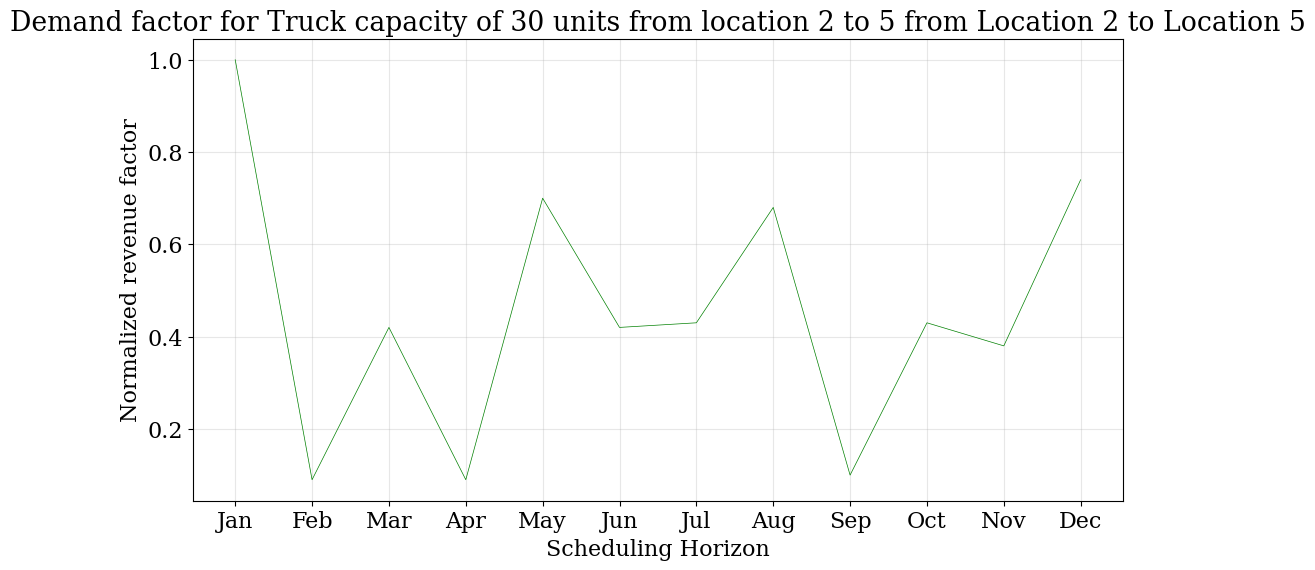

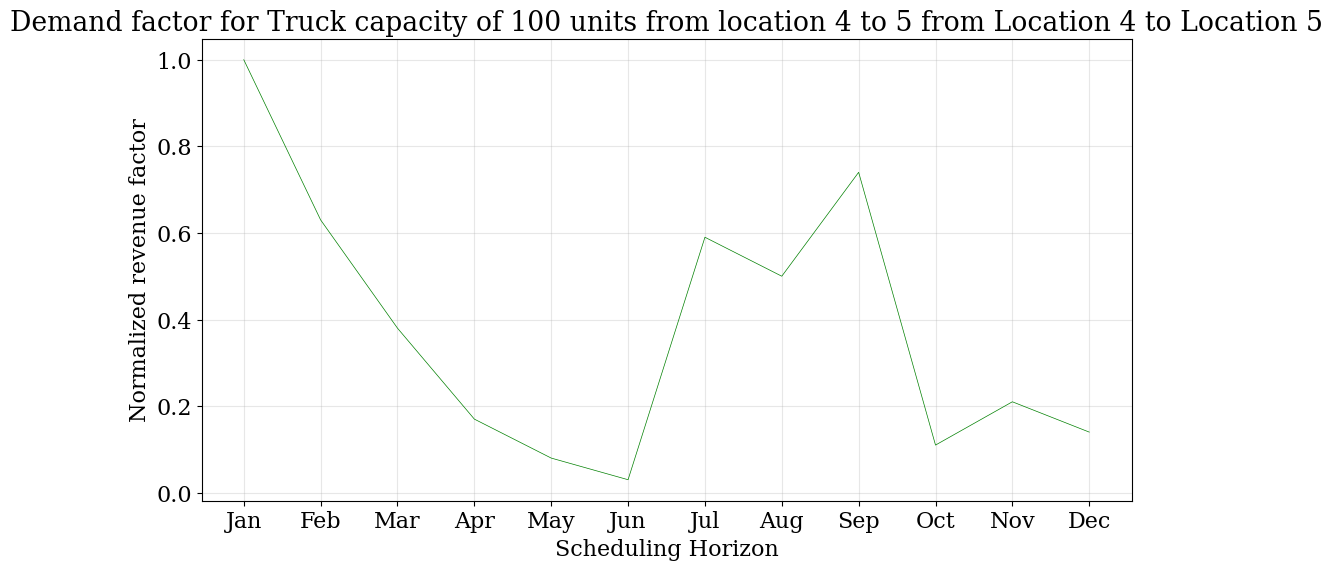

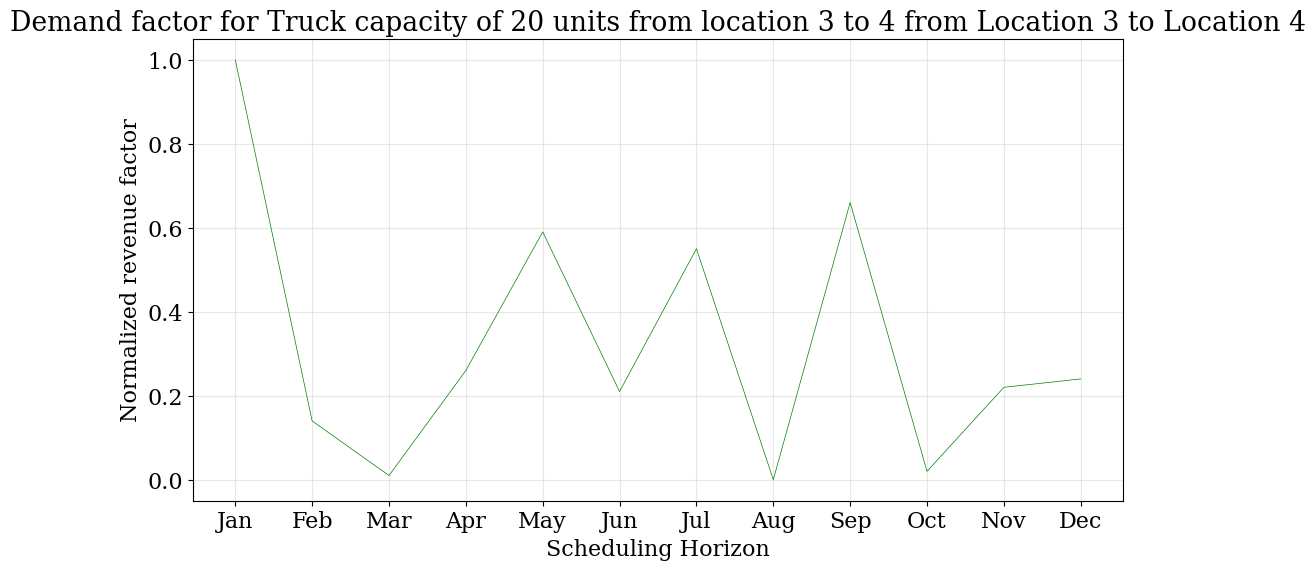

In [54]:
plot_scenario.transport_capacity_factor(scenario=scenario_transport, source=loc2, sink=loc5, transport=truck30_25, color='green')

plot_scenario.transport_capacity_factor(scenario=scenario_transport, source=loc4, sink=loc5, transport=truck100_45, color='green')
plot_scenario.transport_capacity_factor(scenario=scenario_transport, source=loc3, sink=loc4, transport=truck20_34, color='green')

In [55]:
problem_mincost = formulate(scenario=scenario_transport,
                            constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.NETWORK, Constraints.RESOURCE_BALANCE,
                                         Constraints.INVENTORY, Constraints.PRODUCTION,  Constraints.DEMAND},
                            demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint production mode
constraint inventory balance
constraint inventory network
constraint resource export
constraint transport export
constraint export
constraint transport capacity UB
constraint transport capacity LB
constraint transport capex
constraint transport network capex
constraint transport export network
constraint transport vopex
constraint transport network vopex
constraint transport fopex
constraint transport network fopex
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand penalty
objective cost w demand penalty


In [56]:
results_mincost = solve(scenario=scenario_transport, instance=problem_mincost, solver='gurobi', name='MILP')

Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 931601 rows, 2806340 columns and 1278027 nonzeros
Model fingerprint: 0xaba7bfeb
Variable types: 2805276 continuous, 1064 integer (1064 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+03]
  Objective range  [1e+00, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+03]
Found heuristic solution: objective 1.800000e+07
Presolve removed 903830 rows and 2790065 columns
Presolve time: 0.88s
Presolved: 27771 rows, 16275 columns, 77001 nonzeros
Variable types: 16216 continuous, 59 integer (59 binary)

Root relaxation: objective 3.627324e+06, 7295 iterations, 0.22 seconds (0.40 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0 

In [57]:
sum(value for key, value in results_mincost.output['S'].items() if key[0] == 'loc5' and key[1] == 'com1_sold') / 36000

0.8256111111111153

In [58]:
min(value for key, value in results_mincost.output['S'].items() if key[0] == 'loc5' and key[1] == 'com1_sold')

55.6

In [59]:
print(*[(key, value) for key, value in results_mincost.output['X_F'].items() if value == 1], sep='\n')

(('loc1', 'loc2', 'truck50_12', 0), 1.0)
(('loc1', 'loc3', 'truck30_13', 0), 1.0)
(('loc2', 'loc4', 'truck50_24', 0), 1.0)
(('loc2', 'loc5', 'truck30_25', 0), 1.0)
(('loc3', 'loc4', 'truck20_34', 0), 1.0)
(('loc4', 'loc5', 'truck100_45', 0), 1.0)
(('loc4', 'loc7', 'truck40_47', 0), 1.0)
(('loc6', 'loc4', 'truck50_64', 0), 1.0)
(('loc7', 'loc5', 'truck40_75', 0), 1.0)


In [60]:
print(*[(key, value) for key, value in results_mincost.output['X_F'].items() if value == 0], sep='\n')

(('loc2', 'loc1', 'truck50_21', 0), -0.0)
(('loc3', 'loc1', 'truck30_31', 0), -0.0)
(('loc4', 'loc2', 'truck50_42', 0), -0.0)
(('loc4', 'loc3', 'truck20_43', 0), -0.0)
(('loc4', 'loc6', 'truck50_46', 0), -0.0)
(('loc5', 'loc2', 'truck30_52', 0), -0.0)
(('loc5', 'loc4', 'truck100_54', 0), -0.0)
(('loc5', 'loc7', 'truck40_57', 0), -0.0)
(('loc7', 'loc4', 'truck40_74', 0), -0.0)


In [61]:
print(*[(key, value) for key, value in results_mincost.output['X_P'].items() if value == 1 and key[0]=='loc7'], sep='\n')

(('loc7', 'com1_loc7_send', 0), 1.0)
(('loc7', 'com1_process', 0), 1.0)
(('loc7', 'com1_receive_loc4', 0), 1.0)
(('loc7', 'com1_store20_discharge', 0), 1.0)


In [62]:
scenario_transport.location_process_dict

{'loc5': {'com1_loc5_send',
  'com1_process',
  'com1_receive_loc2',
  'com1_receive_loc4',
  'com1_receive_loc7',
  'com1_store50',
  'com1_store50_discharge',
  'sell com1'},
 'loc3': {'com1_loc3_send',
  'com1_process',
  'com1_receive_loc1',
  'com1_receive_loc4',
  'com1_store20',
  'com1_store20_discharge'},
 'loc4': {'com1_loc4_send',
  'com1_process',
  'com1_receive_loc2',
  'com1_receive_loc3',
  'com1_receive_loc5',
  'com1_receive_loc6',
  'com1_receive_loc7',
  'com1_store50',
  'com1_store50_discharge'},
 'loc6': {'com1_loc6_send',
  'com1_process',
  'com1_receive_loc4',
  'com1_store10',
  'com1_store10_discharge',
  'procure com1'},
 'loc7': {'com1_loc7_send',
  'com1_process',
  'com1_receive_loc4',
  'com1_receive_loc5',
  'com1_store20',
  'com1_store20_discharge'},
 'loc1': {'com1_loc1_send',
  'com1_process',
  'com1_receive_loc2',
  'com1_receive_loc3',
  'com1_store20',
  'com1_store20_discharge',
  'procure com1'},
 'loc2': {'com1_loc2_send',
  'com1_process',


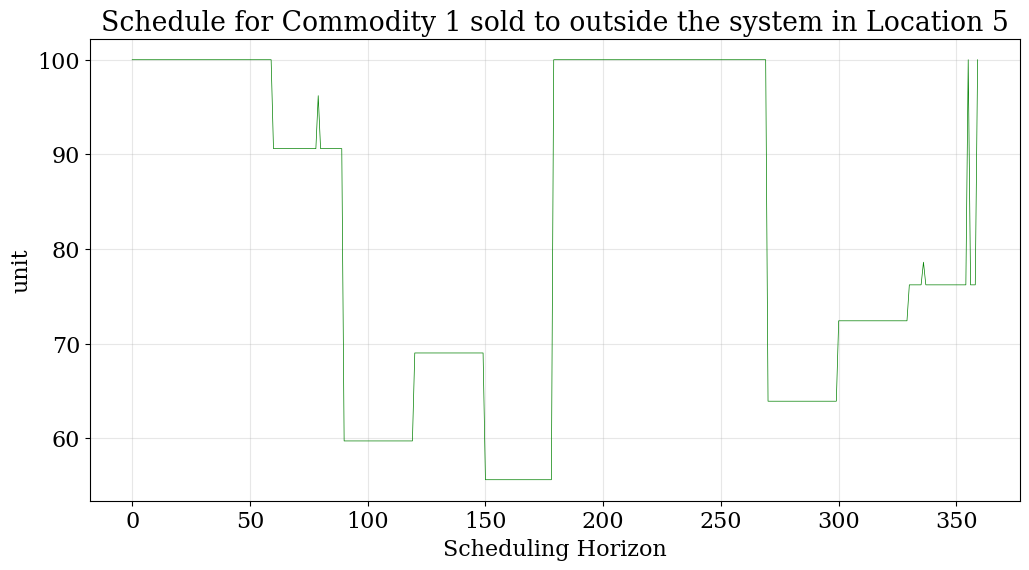

In [63]:
plot_results.schedule(results=results_mincost, y_axis='S', component='com1_sold', location='loc5', color='green')

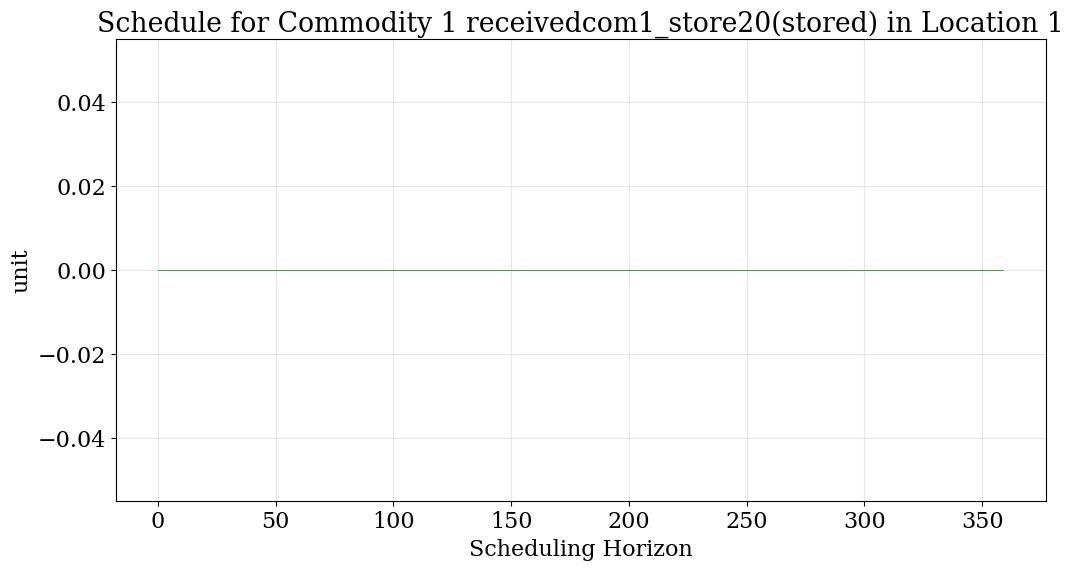

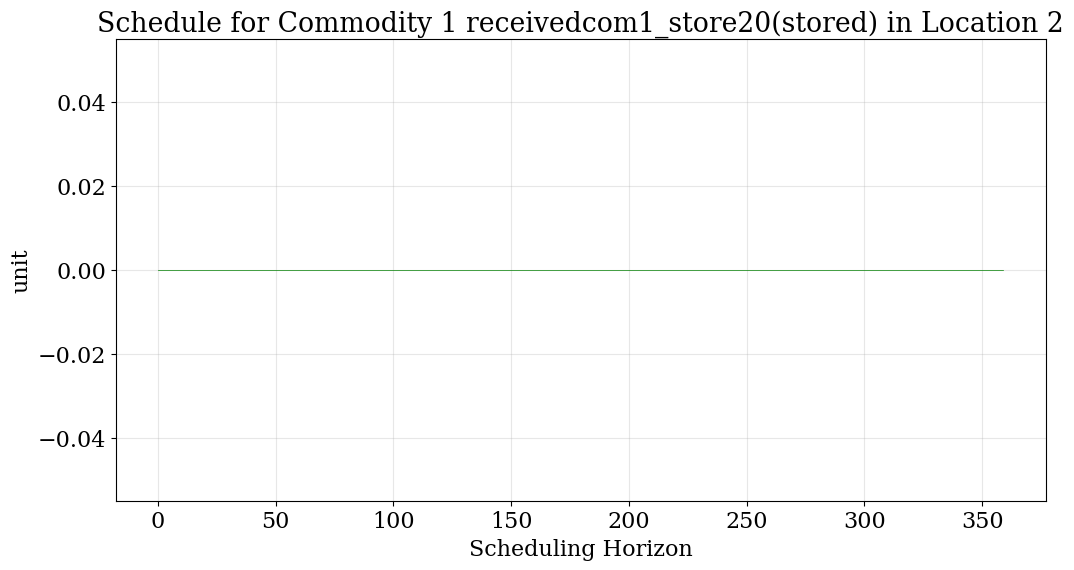

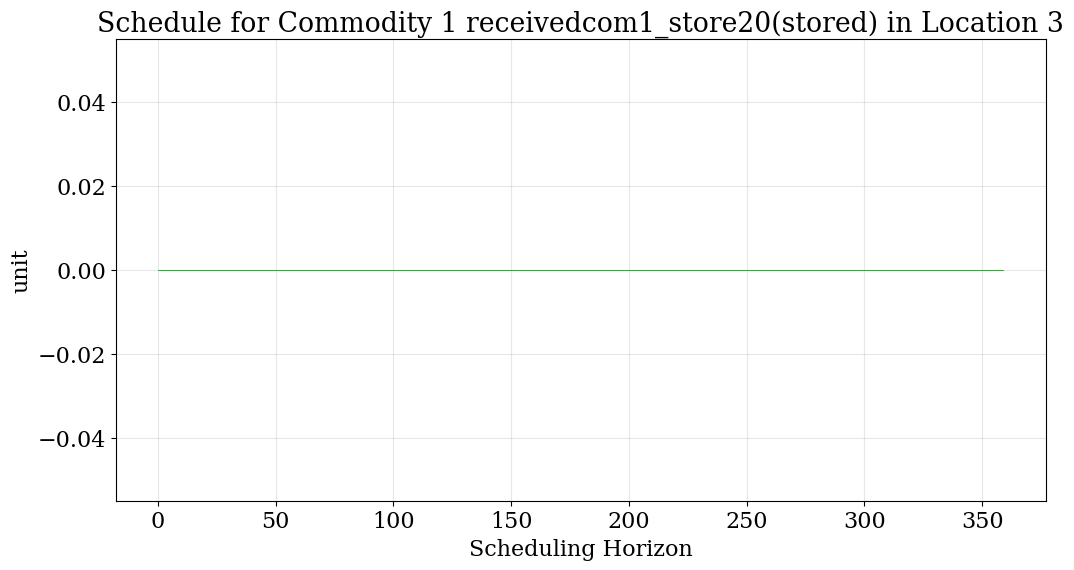

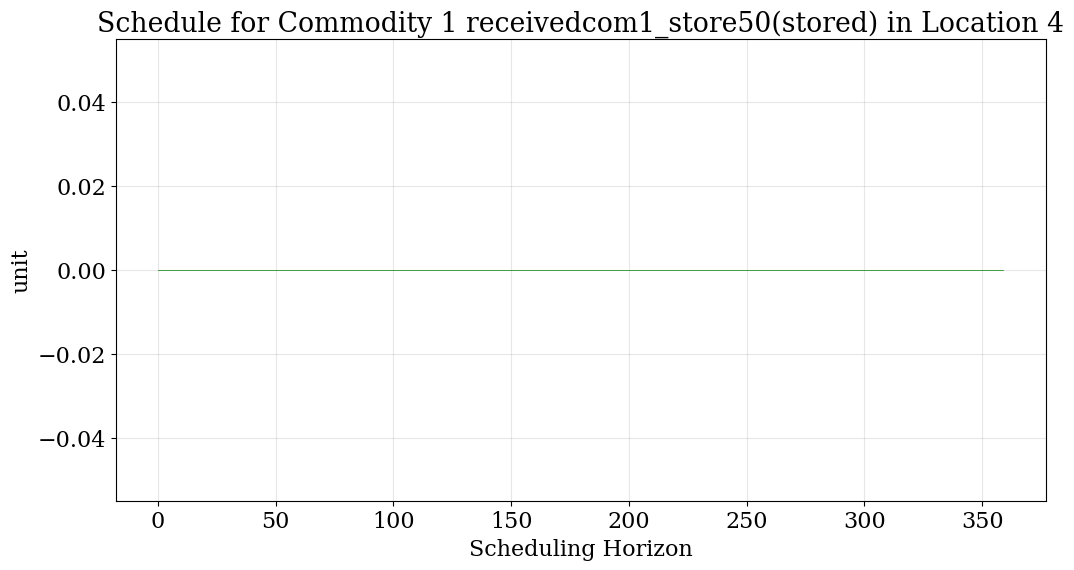

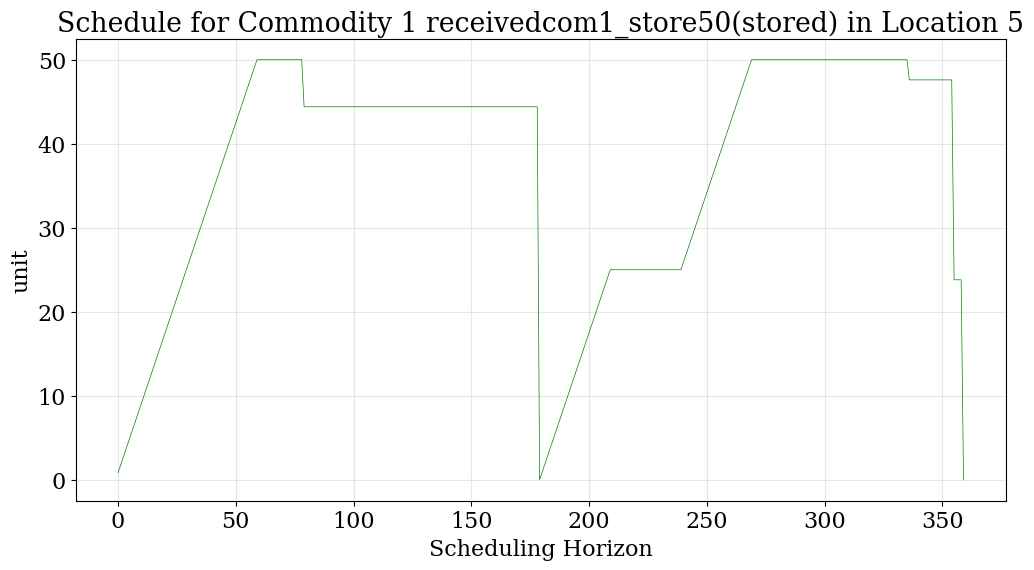

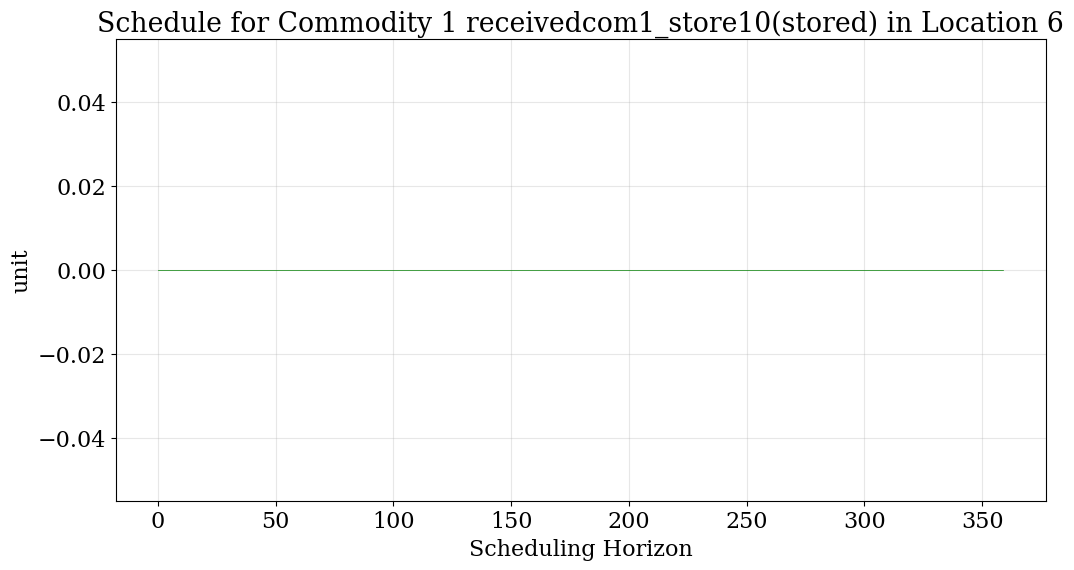

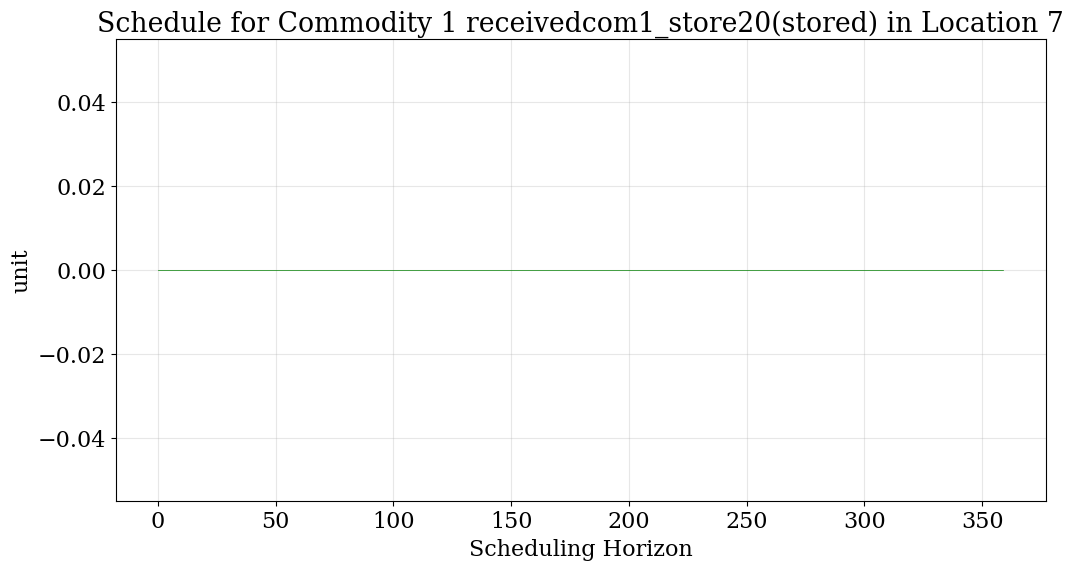

In [64]:
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store20_com1_in_stored', location='loc1', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store20_com1_in_stored', location='loc2', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store20_com1_in_stored', location='loc3', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store50_com1_in_stored', location='loc4', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store50_com1_in_stored', location='loc5', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store10_com1_in_stored', location='loc6', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store20_com1_in_stored', location='loc7', color='green')

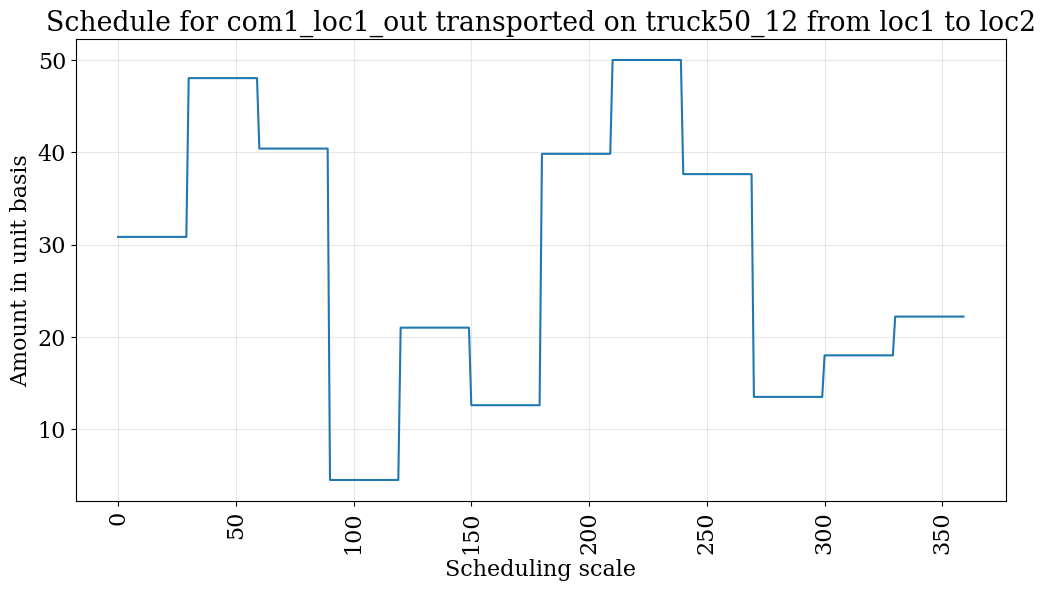

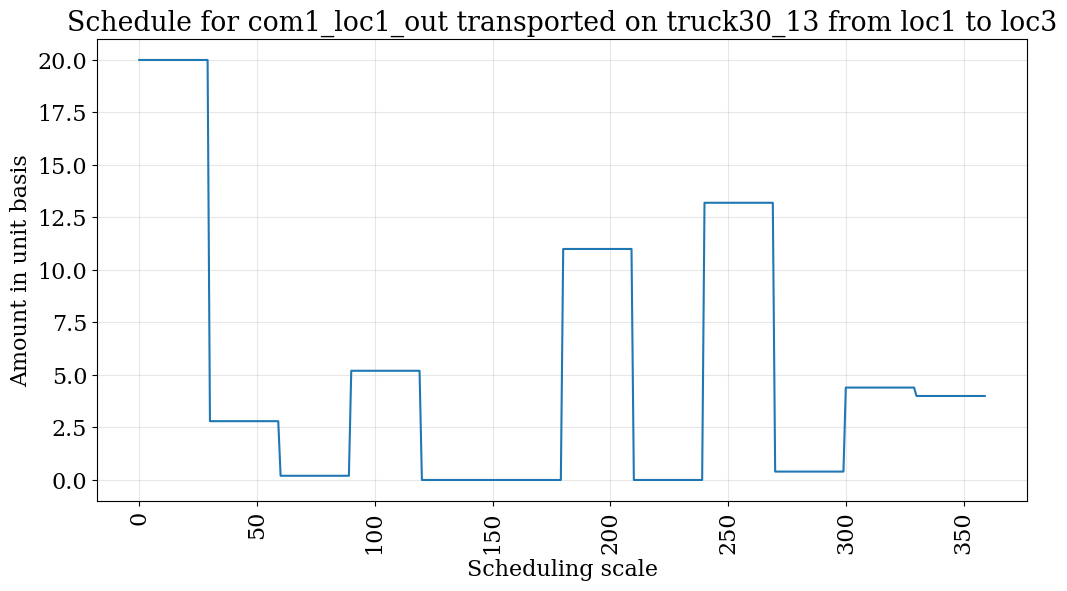

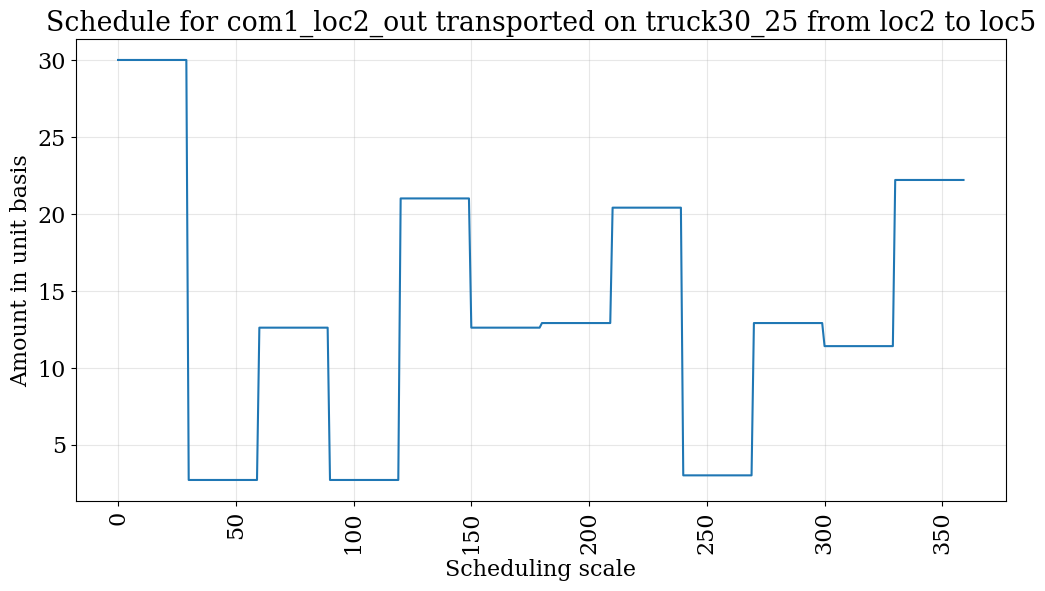

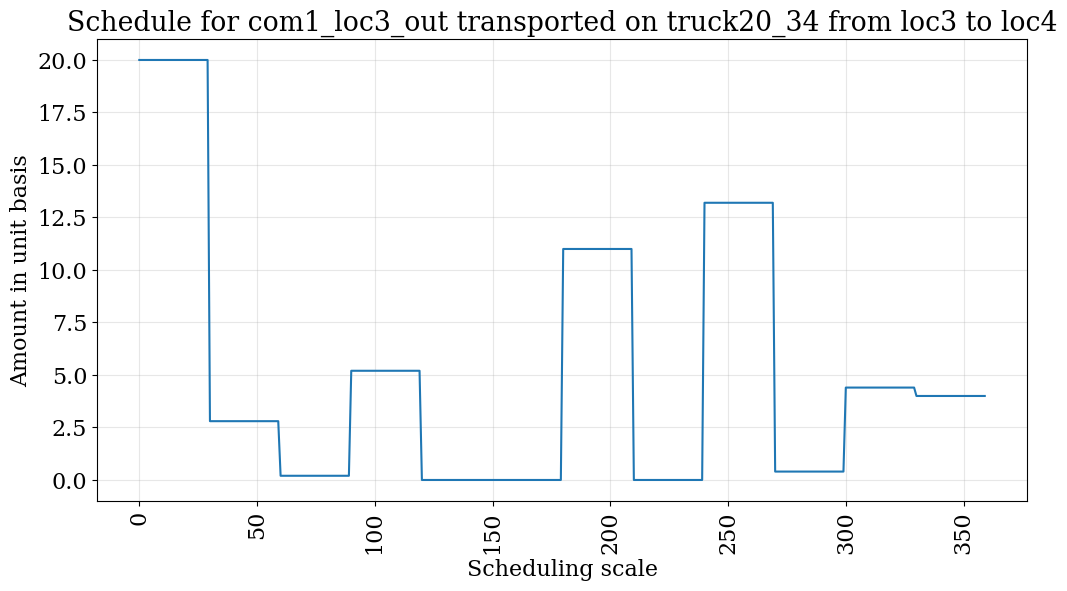

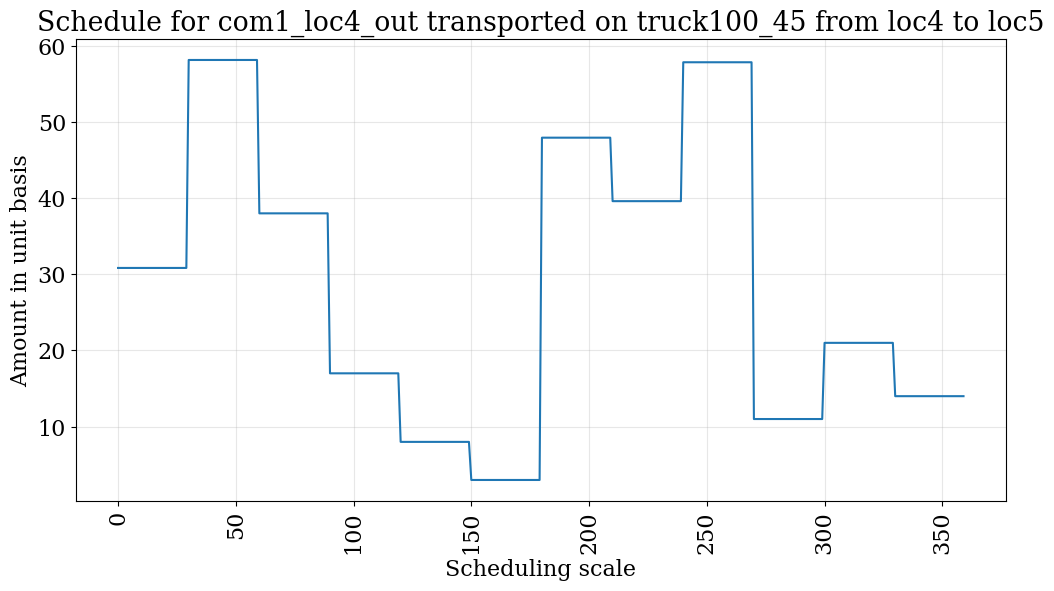

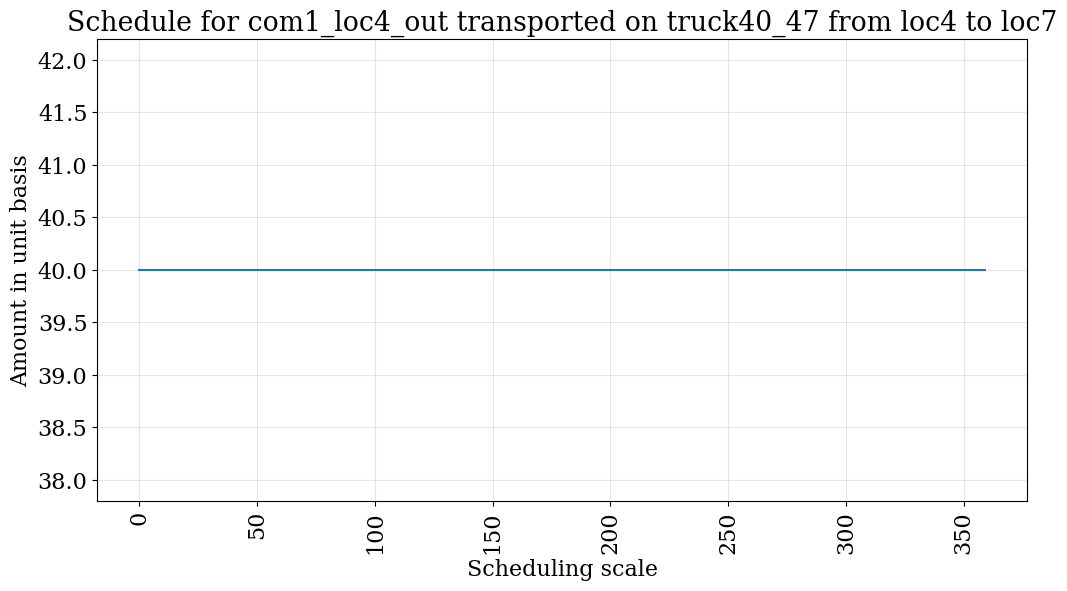

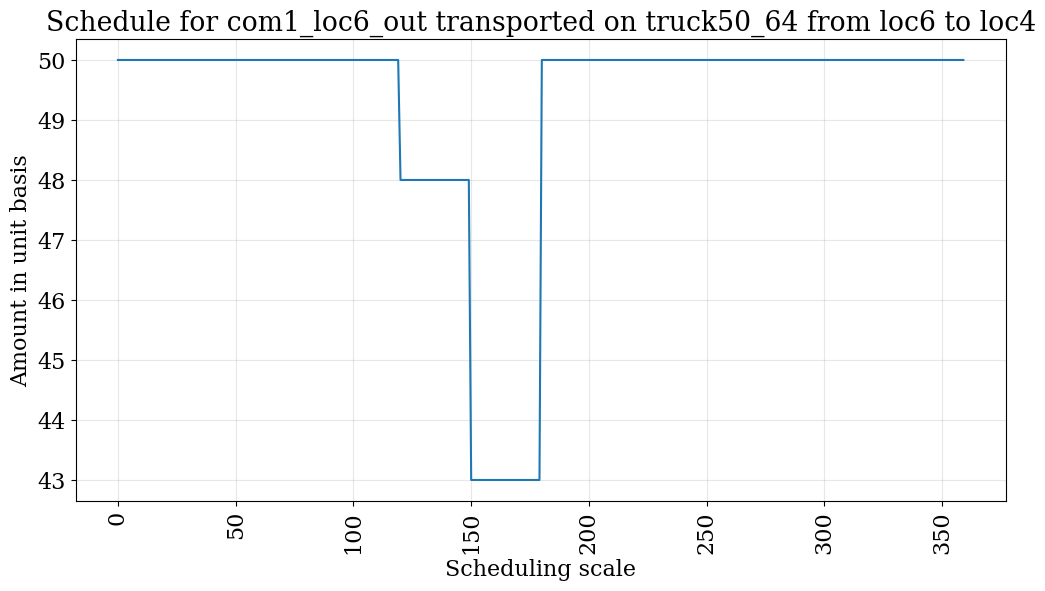

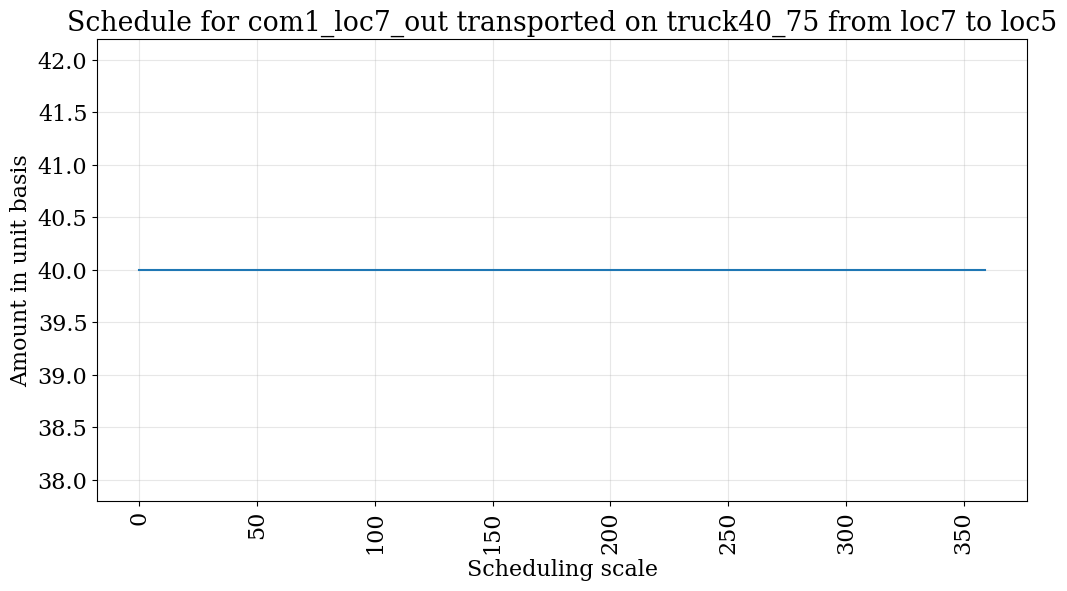

In [65]:
plot_results.transport(results=results_mincost, source='loc1', sink='loc2', transport='truck50_12',
                       resource='com1_loc1_out')
plot_results.transport(results=results_mincost, source='loc1', sink='loc3', transport='truck30_13',
                       resource='com1_loc1_out')
plot_results.transport(results=results_mincost, source='loc2', sink='loc5', transport='truck30_25',
                       resource='com1_loc2_out')
plot_results.transport(results=results_mincost, source='loc3', sink='loc4', transport='truck20_34',
                       resource='com1_loc3_out')
plot_results.transport(results=results_mincost, source='loc4', sink='loc5', transport='truck100_45',
                       resource='com1_loc4_out')
plot_results.transport(results=results_mincost, source='loc4', sink='loc7', transport='truck40_47',
                       resource='com1_loc4_out')
plot_results.transport(results=results_mincost, source='loc6', sink='loc4', transport='truck50_64',
                       resource='com1_loc6_out')
plot_results.transport(results=results_mincost, source='loc7', sink='loc5', transport='truck40_75',
                       resource='com1_loc7_out')